In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from tensorboardX import SummaryWriter
from time import time
import cv2

Populating the interactive namespace from numpy and matplotlib


/home/xupeng/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np
import random
import pickle, h5py, time, argparse, itertools, datetime

import torch
import torch.nn as nn
import torch.utils.data

In [3]:
cd /home/xupeng/projects/membrane

/home/xupeng/projects/membrane


In [4]:
sys.path.append('bin/DeepGlobe-Road-Extraction-Challenge-master/networks/')
sys.path.append('bin/DeepGlobe-Road-Extraction-Challenge-master/')
sys.path.append('bin/')

In [5]:
from augmentation import IntensityAugment, simpleaug_train_produce
from augmentation import apply_elastic_transform, apply_deform

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable as V
import cv2
import os
import numpy as np
from time import time
from networks.unet import Unet
from networks.dunet import Dunet
from networks.dinknet import LinkNet34, DinkNet34, DinkNet50, DinkNet101, DinkNet34_less_pool
from framework import MyFrame
from loss import dice_bce_loss
from data import ImageFolder,default_loader

In [6]:
model = DinkNet34()
model

DinkNet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

In [7]:
from torchviz import make_dot, make_dot_from_trace
from torch.autograd import Variable

In [16]:
model = model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = Variable(torch.randn(1,3,1024,1024))
y = model(x)
x, y = x.to(device), y.to(device)

make_dot(y.mean(), params=dict(model.named_parameters()))

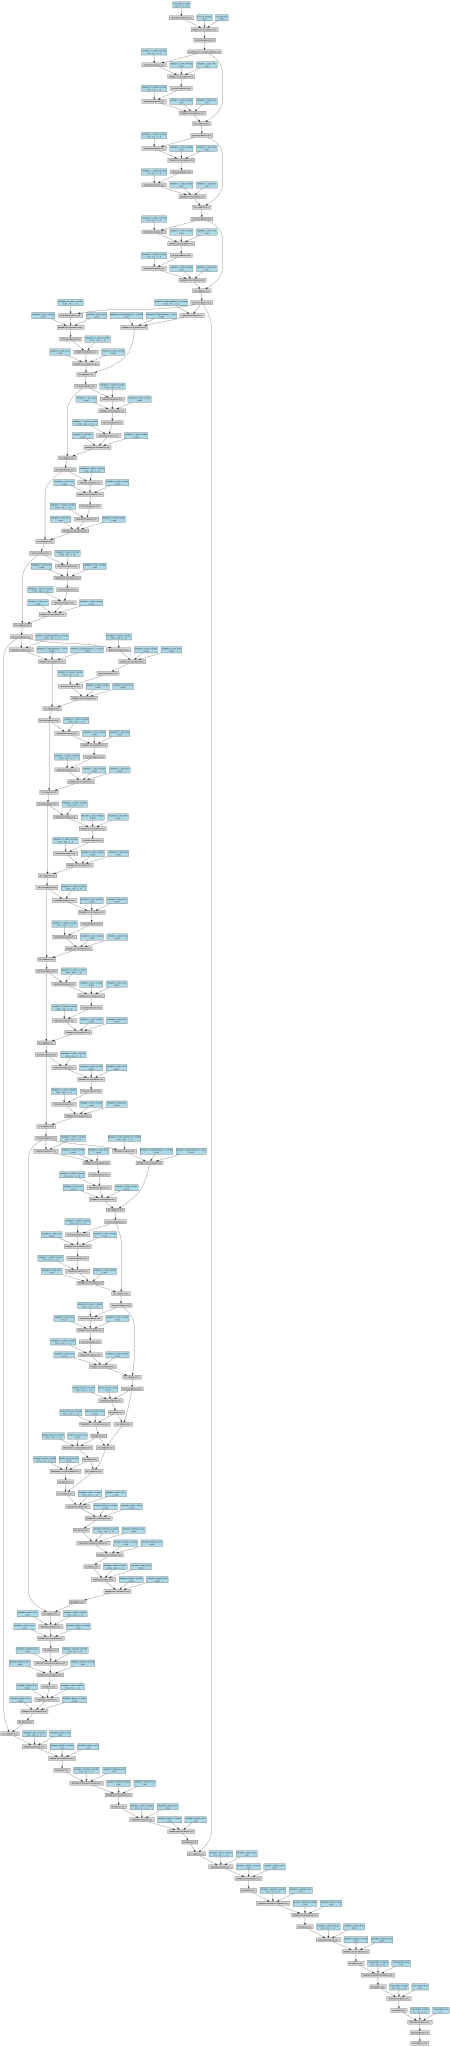

In [8]:
x = Variable(torch.randn(1,3,1024,1024))
y = model(x)
make_dot(y.mean(), params=dict(model.named_parameters()))

In [9]:
dots = make_dot(y.mean(), params=dict(model.named_parameters()))
dots.view('model.svg')

In [19]:
class DinkNet34(nn.Module):
    def __init__(self, num_classes=1, num_channels=3):
        super(DinkNet34, self).__init__()

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        self.dblock = Dblock(512)

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        # Center
        e4 = self.dblock(e4)

        # Decoder
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        
        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return F.sigmoid(out)

In [21]:
from torchvision import models

In [8]:
SHAPE = (1024,1024)
#ROOT = 'dataset/train/'
#imagelist = filter(lambda x: x.find('sat')!=-1, os.listdir(ROOT))
#trainlist = map(lambda x: x[:-8], imagelist)
NAME = 'log01_dink34'
BATCHSIZE_PER_CARD = 1
#dataset = ImageFolder(trainlist, ROOT)
batchsize = torch.cuda.device_count() * BATCHSIZE_PER_CARD

In [9]:
batchsize

1L

In [7]:
with h5py.File('data/train_set/marco/marco_1435_mask') as f:
    masks = f['main'][:3,:512,:512]
with h5py.File('data/train_set/marco/marco_1435_em') as f:
    imgs = f['main'][:3,:512,:512]
imgs = np.repeat(imgs.reshape(-1,1,512,512),3,axis=1)

In [53]:
def default_loader(id, root):
    img = cv2.imread(os.path.join(root,'{}_sat.jpg').format(id))
    mask = cv2.imread(os.path.join(root+'{}_mask.png').format(id), cv2.IMREAD_GRAYSCALE)
    
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-30, 30),
                                   sat_shift_limit=(-5, 5),
                                   val_shift_limit=(-15, 15))
    
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.1, 0.1),
                                       scale_limit=(-0.1, 0.1),
                                       aspect_limit=(-0.1, 0.1),
                                       rotate_limit=(-0, 0))
    img, mask = randomHorizontalFlip(img, mask)
    img, mask = randomVerticleFlip(img, mask)
    img, mask = randomRotate90(img, mask)
    
    mask = np.expand_dims(mask, axis=2)
    img = np.array(img, np.float32).transpose(2,0,1)/255.0 * 3.2 - 1.6
    mask = np.array(mask, np.float32).transpose(2,0,1)/255.0
    mask[mask>=0.5] = 1
    mask[mask<=0.5] = 0
    #mask = abs(mask-1)
    return img, mask
class ImageFolder(data.Dataset):

    def __init__(self, trainlist, root):
        self.ids = trainlist
        self.loader = default_loader
        self.root = root

    def __getitem__(self, index):
        id = self.ids[index]
        img, mask = self.loader(id, self.root)
        img = torch.Tensor(img)
        mask = torch.Tensor(mask)
        return img, mask

    def __len__(self):
        return len(self.ids)

In [10]:
SHAPE = (1024,1024)
ROOT = 'datasets/train/'
imagelist = filter(lambda x: x.find('sat')!=-1, os.listdir(ROOT))
trainlist = map(lambda x: x[:-8], imagelist)
imgs = scipy.misc.imread('datasets/deeproad-master/data/deepglobe/road/smpl/train/X/img/195081_sat.jpg')
masks = scipy.misc.imread('datasets/deeproad-master/data/deepglobe/road/smpl/train/y/mask/195081_mask.png')
dataset = ImageFolder(trainlist, ROOT)

In [12]:
for i in dataset:
    print (i[0].size())
    print (i[1].size())

torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])


In [9]:
imgs = np.zeros([4,3,1024,1024])
masks = np.zeros([4,1,1024,1024])

In [10]:
imgs.shape, masks.shape

((4, 3, 1024, 1024), (4, 1, 1024, 1024))

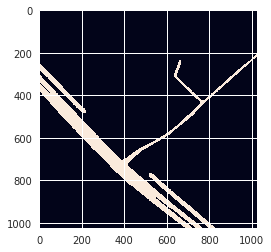

In [84]:
imshow(masks[:,:,0])

In [13]:
from data import default_loader
os.path.join('datasets/train/','{}_sat.jpg').format(trainlist[0])

In [155]:
dataset = ImageFolder(trainlist, ROOT)
dataset[0][1].shape

torch.Size([1, 1024, 1024])

In [15]:
img = torch.Tensor(imgs)
mask = torch.Tensor(masks)
img.shape,mask.shape

(torch.Size([1024, 1024, 3]), torch.Size([1024, 1024, 3]))

In [171]:
dataset = {}
for i in range(img.size()[0]):
    dataset[i] = {}
    dataset[i][0] = img[i]
    dataset[i][1] = mask[i]

In [172]:
img.size(), mask.size()

(torch.Size([4, 3, 1024, 1024]), torch.Size([4, 1, 1024, 1024]))

In [180]:
dataset[0][1].shape

torch.Size([1, 1024, 1024])

In [174]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batchsize,
    shuffle=True,
    num_workers=4)
solver = MyFrame(DinkNet34, dice_bce_loss, 2e-4)

In [179]:
mylog = open('logs/'+NAME+'.log','w')
tic = time()
no_optim = 0
total_epoch = 10
train_epoch_best_loss = 100.

log_name = 'testdinknet'
writer = SummaryWriter('runs/'+log_name)

for epoch in range(1, total_epoch + 1):
    data_loader_iter = iter(data_loader)
    train_epoch_loss = 0
    for img, mask in data_loader_iter:
        print 'image size: ', img.size()
        print 'mask size: ', mask.size()
        solver.set_input(img, mask)
        train_loss = solver.optimize()
        train_epoch_loss += train_loss
    train_epoch_loss /= len(data_loader_iter)
    print >> mylog, '********'
    print >> mylog, 'epoch:',epoch,'    time:',int(time()-tic)
    print >> mylog, 'train_loss:',train_epoch_loss
    print >> mylog, 'SHAPE:',SHAPE
    print '********'
    print 'epoch:',epoch,'    time:',int(time()-tic)
    print 'train_loss:',train_epoch_loss
    print 'SHAPE:',SHAPE
    
    # tensorboardX summary
    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('train_loss', train_epoch_loss .item(), epoch)
    
    if train_epoch_loss >= train_epoch_best_loss:
        no_optim += 1
    else:
        no_optim = 0
        train_epoch_best_loss = train_epoch_loss
        solver.save('weights/'+NAME+'.th')
    if no_optim > 6:
        print >> mylog, 'early stop at %d epoch' % epoch
        print 'early stop at %d epoch' % epoch
        break
    if no_optim > 3:
        if solver.old_lr < 5e-7:
            break
        solver.load('weights/'+NAME+'.th')
        solver.update_lr(5.0, factor = True, mylog = mylog)
    mylog.flush()
    
print >> mylog, 'Finish!'
print 'Finish!'
mylog.close()

AttributeError: 'int' object has no attribute 'cuda'

## prepare dataloader

In [7]:
with h5py.File('data/train_set/marco/coloredmaskmip0whole.h5') as f:
    masks = f['main'][:10]
with h5py.File('data/train_set/marco/emmip0whole.h5') as f:
    imgs = f['main'][:10]

In [8]:
masks.shape, imgs.shape

((10, 1112, 1734), (10, 1112, 1734))

In [27]:
new_imgs = np.stack((imgs,)*3, 1)
new_masks = np.stack((masks,)*1, 1)

In [35]:
new_imgs.shape,new_masks.shape

((1434, 3, 1112, 1734), (1434, 1, 1112, 1734))

In [30]:
with h5py.File('data/train_set/marco/maskfor2Dlinknet.h5') as f:
    f.create_dataset('main',data=new_masks)
with h5py.File('data/train_set/marco/emfor2Dlinknet.h5') as f:
    f.create_dataset('main',data=new_imgs)

In [33]:
imgs.dtype

dtype('uint8')

In [34]:
with h5py.File('data/train_set/marco/coloredmaskmip0whole_half.h5') as f:
    f.create_dataset('main',data=masks[-800:])
with h5py.File('data/train_set/marco/emmip0whole_half.h5') as f:
    f.create_dataset('main',data=imgs[-800:])

In [9]:
imgs = imgs[:10]
masks = masks[:10]

In [10]:
train_input= imgs/255.0
train_label = masks
model_io_size = np.array([4,512,512])

In [11]:
train_input.shape, train_label.shape

((10, 1112, 1734), (10, 1112, 1734))

In [12]:
train_input = np.stack((train_input,)*1,0)
train_label = np.stack((train_label,)*1,0)

In [13]:
train_input.shape, train_label.shape

((1, 10, 1112, 1734), (1, 10, 1112, 1734))

In [16]:
dataset = SynapseDataset(volume=train_input, label=train_label, vol_input_size=model_io_size, \
                                 vol_label_size=model_io_size, data_aug = True, mode = 'train')

In [17]:
dataset[0][0].shape,dataset[0][1].shape

(torch.Size([1, 4, 512, 512]), torch.Size([1, 4, 512, 512]))

In [18]:
opt ='train'
SHUFFLE = (opt=='train')
img_loader =  torch.utils.data.DataLoader(
            dataset, batch_size=2, shuffle=SHUFFLE, collate_fn = collate_fn,
            num_workers=1, pin_memory=True)

In [ ]:
for data in img_loader:
    print (data[0].size())

torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Si

torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Si

torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Si

torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Si

torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Size([2, 1, 4, 512, 512])
torch.Si

Process Process-6:
Traceback (most recent call last):
  File "/home/xupeng/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/xupeng/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xupeng/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
    data_queue.put((idx, samples))
  File "/home/xupeng/anaconda2/lib/python2.7/multiprocessing/queues.py", line 390, in put
    return send(obj)
  File "/home/xupeng/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 17, in send
    ForkingPickler(buf, pickle.HIGHEST_PROTOCOL).dump(obj)
  File "/home/xupeng/anaconda2/lib/python2.7/pickle.py", line 224, in dump
    self.save(obj)
  File "/home/xupeng/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/home/xupeng/anaconda2/lib/py

In [ ]:
for i, (volume, label) in tqdm(enumerate(img_loader)):
    print (i, volume.size(), label.size())

4it [00:02,  1.72it/s]

0 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
1 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
2 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
3 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
4 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


7it [00:02,  2.71it/s]

5 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
6 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
7 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


10it [00:02,  3.40it/s]

8 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
9 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
10 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


12it [00:03,  3.88it/s]

11 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
12 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


16it [00:03,  4.70it/s]

13 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
14 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
15 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


18it [00:03,  5.02it/s]

16 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
17 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


20it [00:03,  5.25it/s]

18 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
19 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
20 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


25it [00:04,  5.96it/s]

21 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
22 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
23 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
24 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


27it [00:04,  5.97it/s]

25 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
26 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


29it [00:04,  6.06it/s]

27 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
28 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


31it [00:05,  6.16it/s]

29 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
30 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


33it [00:05,  6.33it/s]

31 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
32 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


35it [00:05,  6.43it/s]

33 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
34 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
35 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


39it [00:05,  6.75it/s]

36 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
37 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
38 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


41it [00:05,  6.88it/s]

39 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
40 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
41 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


43it [00:06,  7.02it/s]

42 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
43 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


45it [00:06,  7.08it/s]

44 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
45 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


49it [00:06,  7.33it/s]

46 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
47 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
48 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


51it [00:06,  7.37it/s]

49 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
50 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
51 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


53it [00:07,  7.51it/s]

52 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
53 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


57it [00:07,  7.68it/s]

54 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
55 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
56 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


59it [00:07,  7.76it/s]

57 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
58 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
59 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


63it [00:07,  7.94it/s]

60 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
61 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
62 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


65it [00:08,  7.92it/s]

63 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
64 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


67it [00:08,  7.98it/s]

65 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
66 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


69it [00:08,  8.04it/s]

67 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
68 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
69 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


71it [00:08,  8.07it/s]

70 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
71 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


75it [00:09,  8.16it/s]

72 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
73 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
74 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


77it [00:09,  8.24it/s]

75 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
76 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
77 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


81it [00:09,  8.28it/s]

78 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
79 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
80 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


83it [00:10,  8.29it/s]

81 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
82 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
83 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


86it [00:10,  8.41it/s]

84 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
85 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
86 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


91it [00:10,  8.65it/s]

87 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
88 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
89 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
90 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


93it [00:10,  8.61it/s]

91 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
92 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


95it [00:11,  8.60it/s]

93 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
94 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


97it [00:11,  8.64it/s]

95 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
96 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
97 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


101it [00:11,  8.69it/s]

98 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
99 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
100 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


103it [00:11,  8.79it/s]

101 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
102 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
103 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


107it [00:12,  8.83it/s]

104 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
105 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
106 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
107 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


109it [00:12,  8.90it/s]

108 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
109 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


111it [00:12,  8.90it/s]

110 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


113it [00:12,  8.83it/s]

111 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
112 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


115it [00:12,  8.86it/s]

113 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
114 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
115 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


119it [00:13,  8.95it/s]

116 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
117 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
118 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


121it [00:13,  8.97it/s]

119 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
120 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
121 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


123it [00:13,  8.96it/s]

122 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
123 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


126it [00:14,  8.91it/s]

124 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
125 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


128it [00:14,  8.85it/s]

126 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
127 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


131it [00:14,  8.91it/s]

128 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
129 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
130 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


134it [00:14,  9.03it/s]

131 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
132 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
133 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


136it [00:15,  9.04it/s]

134 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
135 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


138it [00:15,  8.96it/s]

136 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
137 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


140it [00:15,  8.96it/s]

138 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
139 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


142it [00:15,  8.92it/s]

140 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
141 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


144it [00:16,  8.95it/s]

142 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
143 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


146it [00:16,  8.92it/s]

144 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
145 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


147it [00:16,  8.91it/s]

146 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
147 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
148 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


150it [00:16,  8.98it/s]

149 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
150 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


153it [00:17,  8.97it/s]

151 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
152 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
153 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


155it [00:17,  8.93it/s]

154 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
155 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


158it [00:17,  8.88it/s]

156 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
157 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
158 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


162it [00:18,  8.94it/s]

159 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
160 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
161 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


164it [00:18,  8.97it/s]

162 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
163 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


166it [00:18,  8.97it/s]

164 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
165 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


168it [00:18,  8.99it/s]

166 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
167 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


170it [00:19,  8.93it/s]

168 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
169 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


172it [00:19,  8.94it/s]

170 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
171 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
172 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


176it [00:19,  9.02it/s]

173 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
174 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
175 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


178it [00:19,  9.03it/s]

176 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
177 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


180it [00:19,  9.00it/s]

178 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
179 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


182it [00:20,  8.98it/s]

180 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
181 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


184it [00:20,  8.93it/s]

182 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
183 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


186it [00:20,  8.90it/s]

184 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
185 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
186 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


189it [00:21,  8.91it/s]

187 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
188 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


192it [00:21,  8.92it/s]

189 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
190 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
191 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
192 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


194it [00:21,  8.95it/s]

193 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
194 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


197it [00:22,  8.93it/s]

195 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
196 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


198it [00:22,  8.93it/s]

197 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
198 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
199 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


201it [00:22,  8.97it/s]

200 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
201 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


203it [00:22,  8.98it/s]

202 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
203 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


206it [00:22,  8.98it/s]

204 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
205 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


208it [00:23,  8.92it/s]

206 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
207 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


210it [00:23,  8.91it/s]

208 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
209 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
210 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


213it [00:23,  8.92it/s]

211 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
212 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


215it [00:24,  8.94it/s]

213 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
214 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
215 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


219it [00:24,  9.00it/s]

216 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
217 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
218 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


223it [00:24,  9.03it/s]

219 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
220 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
221 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
222 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


225it [00:24,  9.03it/s]

223 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
224 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
225 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


228it [00:25,  9.10it/s]

226 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
227 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
228 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


232it [00:25,  9.13it/s]

229 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
230 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
231 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


234it [00:25,  9.14it/s]

232 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
233 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


236it [00:25,  9.14it/s]

234 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
235 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


238it [00:26,  9.12it/s]

236 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
237 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


240it [00:26,  9.15it/s]

238 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
239 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
240 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


242it [00:26,  9.13it/s]

241 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
242 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


246it [00:26,  9.15it/s]

243 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
244 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
245 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
246 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


248it [00:27,  9.17it/s]

247 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
248 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


252it [00:27,  9.16it/s]

249 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
250 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
251 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


254it [00:27,  9.16it/s]

252 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
253 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


256it [00:27,  9.16it/s]

254 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
255 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
256 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


260it [00:28,  9.19it/s]

257 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
258 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
259 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


262it [00:28,  9.19it/s]

260 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
261 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
262 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


264it [00:28,  9.20it/s]

263 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
264 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


266it [00:28,  9.19it/s]

265 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
266 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


269it [00:29,  9.18it/s]

267 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
268 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


271it [00:29,  9.18it/s]

269 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])
270 torch.Size([2, 1, 4, 512, 512]) torch.Size([2, 1, 4, 512, 512])


Process Process-1:
Traceback (most recent call last):
  File "/home/xupeng/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/xupeng/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xupeng/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-15-a9a5cf1d7dbe>", line 102, in __getitem__
    out_input = apply_deform(out_input)
  File "bin/DeepGlobe-Road-Extraction-Challenge-master/augmentation.py", line 761, in apply_deform
    transformedimgs[i] = deform_2d(imgs[i], deformation_strength, iterations)
  File "bin/DeepGlobe-Road-Extraction-Challenge-master/augmentation.py", line 747, in deform_2d
    order=3).reshape(int(flow_x.shape[0]**0.5),int(flow_x.shape[0]**0.5))
  File "/home/xupeng/anaconda2/lib/python2.7/site-packages/sci

# try to use 3D version but get 2D

In [15]:
from __future__ import print_function, division
import os, sys
import numpy as np
import random
import pickle, h5py, time, argparse, itertools, datetime

import torch
import torch.nn as nn
import torch.utils.data


# -- 0. utils --
def countVolume(data_sz, vol_sz, stride):
    return 1 + np.ceil((data_sz - vol_sz) / stride.astype(float)).astype(int)

def cropVolume(data, sz, st=[0,0,0]): # C*D*W*H, C=1
    return data[st[0]:st[0]+sz[0], st[1]:st[1]+sz[1], \
            st[2]:st[2]+sz[2]]

def cropVolumeMul(data, sz, st=[0,0,0]): # C*D*W*H, for multi-channel input
    return data[:, st[0]:st[0]+sz[0], st[1]:st[1]+sz[1], \
            st[2]:st[2]+sz[2]]             

# -- 1.0 dataset -- 
# dataset class for synaptic cleft inputs
class SynapseDataset(torch.utils.data.Dataset):
    # assume for test, no warping [hassle to warp it back..]
    def __init__(self,
                 volume, label=None,
                 vol_input_size = (8,64,64),
                 vol_label_size = None,
                 sample_stride = (1,1,1),
                 data_aug = False,
                 mode = 'train'):
        
        self.mode = mode

        # data format
        self.input = volume
        self.label = label
        self.data_aug = data_aug # data augmentation
        
        # samples, channels, depths, rows, cols
        self.input_size = [np.array(x.shape) for x in self.input] # volume size, could be multi-volume input
        self.vol_input_size = np.array(vol_input_size) # model input size
        self.vol_label_size = np.array(vol_label_size) # model label size

        # compute number of samples for each dataset (multi-volume input)
        self.sample_stride = np.array(sample_stride, dtype=np.float32)
        self.sample_size = [ countVolume(self.input_size[x], self.vol_input_size, np.array(self.sample_stride)) \
                            for x in range(len(self.input_size))]
        #total number of possible inputs for each volume
        self.sample_num = np.array([np.prod(x) for x in self.sample_size])
        self.sample_num_a = np.sum(self.sample_num)
        self.sample_num_c = np.cumsum([0] + list(self.sample_num))
        #print(self.sample_num_c)
        assert self.sample_num_c[-1] == self.sample_num_a

        '''
        Image augmentation
        1. self.simple_aug: Simple augmentation, including mirroring and transpose
        2. self.intensity_aug: Intensity augmentation
        '''
        if self.data_aug:
            self.simple_aug = simpleaug_train_produce(model_io_size = self.vol_input_size)
            self.intensity_aug = IntensityAugment(mode='mix', skip_ratio=0.9, CONTRAST_FACTOR=0.005, BRIGHTNESS_FACTOR=0.005)

        # for test
        self.sample_size_vol = [np.array([np.prod(x[1:3]),x[2]]) for x in self.sample_size]

    def __getitem__(self, index):

        if self.mode == 'train':
            # 1. get volume size
            vol_size = self.vol_input_size
            # if self.data_aug is not None: # augmentation
            #     self.data_aug.getParam() # get augmentation parameter
            #     vol_size = self.data_aug.aug_warp[0]
            # train: random sample based on vol_size
            # test: sample based on index

            # reject no-synapse samples with a probability of p 
            seed = np.random.RandomState(index)
            while True:
                pos = self.getPosSeed(vol_size, seed)
                out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])
                if np.sum(out_label) > 100:
                    break
                else:
                    if random.random() > 0.75:
                        break       

            # pos = self.getPos(vol_size, index)

            # 2. get input volume
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            # out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])

            # 3. augmentation
            if self.data_aug: # augmentation
                #if random.random() > 0.5:
                #    out_input, out_label = apply_elastic_transform(out_input, out_label)    
                out_input, out_label = self.simple_aug(out_input, out_label)
                out_input = self.intensity_aug.augment(out_input)
                out_input = apply_deform(out_input)
            
            # 4. class weight
            # add weight to classes to handle data imbalance
            # match input tensor shape
            out_input = torch.from_numpy(out_input.copy())
            out_label = torch.from_numpy(out_label.copy())
            #weight_factor = out_label.float().sum() / torch.prod(torch.tensor(out_label.size()).float())
            #weight_factor = torch.clamp(weight_factor, min=1e-3)
            # the fraction of synaptic cleft pixels, can be 0
            #weight = out_label*(1-weight_factor)/weight_factor + (1-out_label)

            # include the channel dimension
            out_input = out_input.unsqueeze(0)
            out_label = out_label.unsqueeze(0)
            #weight = weight.unsqueeze(0)

            return out_input, out_label#, weight, weight_factor

        elif self.mode == 'test':
            # 1. get volume size
            vol_size = self.vol_input_size  
            # test mode
            pos = self.getPosTest(index)
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_input = torch.Tensor(out_input)
            out_input = out_input.unsqueeze(0)

            return pos, out_input  

    def __len__(self): # number of possible position
        return self.sample_num_a
    
    def getPosDataset(self, index):
        return np.argmax(index<self.sample_num_c)-1 # which dataset

    def getPos(self, vol_size, index):
        pos = [0,0,0,0]
        # support random sampling using the same 'index'
        seed = np.random.RandomState(index)
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos

    def index2zyx(self, index): # for test
        # int division = int(floor(.))
        pos = [0,0,0,0]
        did = self.getPosDataset(index)
        pos[0] = did
        index2 = index - self.sample_num_c[did]
        pos[1:] = self.getPosLocation(index2, self.sample_size_vol[did])
        return pos 

    def getPosLocation(self, index, sz):
        # sz: [y*x, x]
        pos = [0,0,0]
        pos[0] = np.floor(index/sz[0])
        pz_r = index % sz[0]
        pos[1] = np.floor(pz_r/sz[1])
        pos[2] = pz_r % sz[1]
        return pos 

    def getPosTest(self, index):
        pos = self.index2zyx(index)
        for i in range(1,4):
            if pos[i] != self.sample_size[pos[0]][i-1]-1:
                pos[i] = int(pos[i] * self.sample_stride[i-1])
            else:
                pos[i] = int(self.input_size[pos[0]][i-1]-self.vol_input_size[i-1])
        return pos

    def getPosSeed(self, vol_size, seed):
        pos = [0,0,0,0]
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos    

     

# -- 2. misc --
# for dataloader

def collate_fn(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    out_input, out_label = zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label

def collate_fn_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)

    return pos, test_sample

def collate_fn_refine(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    out_input, out_label= zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)
    #roi = torch.stack(roi, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label#, weights, weight_factor, roi   

def collate_fn_refine_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)   

    return pos, test_sample 
def augmentsimple(data, rule):
    assert np.size(rule) == 4 and data.ndim == 3
    # z reflection.
    if rule[0]:
        data = data[::-1, :, :]
    # x reflection.
    if rule[1]:
        data = data[:, :, ::-1]
    # y reflection.
    if rule[2]:
        data = data[:, ::-1, :]
    # Transpose in xy.
    if rule[3]:
        data = data.transpose(0, 2, 1)
    return data


def produce_simple_train_sample(imgs, rule):
    '''
    imgs: 512*512 -> 8*512*512
    '''
    assert imgs.ndim == 3
    return augmentsimple(imgs, rule)
class simpleaug_train_produce():
    def __init__(self, model_io_size=[512, 512]):
        self.model_io_size = model_io_size

    def __call__(self, imgs, mask):
        #print (self.rule)
        rule = np.random.randint(2, size=4)
        imgs_aug = produce_simple_train_sample(imgs, rule)
        mask_aug = produce_simple_train_sample(mask, rule)
        return imgs_aug, mask_aug

    def multi_mask(self, inputs):
        #print (self.rule)
        rule = np.random.randint(2, size=4)
        for idx in range(len(inputs)):
            inputs[idx] = produce_simple_train_sample(inputs[idx], rule)
        return inputs 

In [22]:
# -- 0. utils --
def countVolume(data_sz, vol_sz, stride):
    return 1 + np.ceil((data_sz - vol_sz) / stride.astype(float)).astype(int)

def cropVolume(data, sz, st=[0,0,0]): # C*W*H, C=1
    return data[st[0]:st[0]+sz[0], st[1]:st[1]+sz[1]]

def cropVolumeMul(data, sz, st=[0,0,0]): # C*W*H, for multi-channel input
    return data[:, st[0]:st[0]+sz[0], st[1]:st[1]+sz[1]] 
def collate_fn(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    #out_input, out_label, weights, weight_factor = zip(*batch)
    out_input, out_label = zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label#, weights, weight_factor

def collate_fn_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)

    return pos, test_sample

def collate_fn_refine(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    #out_input, out_label, weights, weight_factor, roi= zip(*batch)
    out_input, out_label, roi= zip(*batch)
    out_input = torch.stack(out_input, 0)
    out_label = torch.stack(out_label, 0)
    #weights = torch.stack(weights, 0)
    roi = torch.stack(roi, 0)

    #weight_factor = np.stack(weight_factor, 0)

    return out_input, out_label#, weights, weight_factor, roi   

def collate_fn_refine_test(batch):
    pos, out_input = zip(*batch)
    test_sample = torch.stack(out_input, 0)   

    return pos, test_sample 


def augmentsimple(data, rule):
    assert np.size(rule) == 3 and data.ndim == 2
    # x reflection.
    if rule[0]:
        data = data[::-1,:]
    # y reflection.
    if rule[1]:
        data = data[:, ::-1]
    # Transpose in xy.
    if rule[2]:
        data = data.transpose(0, 1)
    return data


def produce_simple_train_sample(imgs, rule):
    '''
    imgs: 512*512 -> 8*512*512
    '''
    assert imgs.ndim == 2
    return augmentsimple(imgs, rule)
class simpleaug_train_produce():
    def __init__(self, model_io_size=[512, 512]):
        self.model_io_size = model_io_size

    def __call__(self, imgs, mask):
        #print (self.rule)
        rule = np.random.randint(2, size=3)
        imgs_aug = produce_simple_train_sample(imgs, rule)
        mask_aug = produce_simple_train_sample(mask, rule)
        return imgs_aug, mask_aug

    def multi_mask(self, inputs):
        #print (self.rule)
        rule = np.random.randint(2, size=3)
        for idx in range(len(inputs)):
            inputs[idx] = produce_simple_train_sample(inputs[idx], rule)
        return inputs 

In [23]:
class SynapseDataset(torch.utils.data.Dataset):
    # assume for test, no warping [hassle to warp it back..]
    def __init__(self,
                 volume, label=None,
                 vol_input_size = (512,512),
                 vol_label_size = None,
                 sample_stride = (1,1),
                 data_aug = False,
                 mode = 'train'):
        
        self.mode = mode

        # data format
        self.input = volume
        self.label = label
        self.data_aug = data_aug # data augmentation
        
        # samples, channels, depths, rows, cols
        self.input_size = [np.array(x.shape) for x in self.input] # volume size, could be multi-volume input
        self.vol_input_size = np.array(vol_input_size) # model input size
        self.vol_label_size = np.array(vol_label_size) # model label size
        print (self.input_size[0].shape,self.vol_input_size.shape, self.vol_label_size.shape)

        # compute number of samples for each dataset (multi-volume input)
        self.sample_stride = np.array(sample_stride, dtype=np.float32)
        self.sample_size = [ countVolume(self.input_size[x], self.vol_input_size, np.array(self.sample_stride)) \
                            for x in range(len(self.input_size))]
        #total number of possible inputs for each volume
        self.sample_num = np.array([np.prod(x) for x in self.sample_size])
        self.sample_num_a = np.sum(self.sample_num)
        self.sample_num_c = np.cumsum([0] + list(self.sample_num))
        #print(self.sample_num_c)
        assert self.sample_num_c[-1] == self.sample_num_a

        '''
        Image augmentation
        1. self.simple_aug: Simple augmentation, including mirroring and transpose
        2. self.intensity_aug: Intensity augmentation
        '''
        if self.data_aug:
            self.simple_aug = simpleaug_train_produce(model_io_size = self.vol_input_size)
            #self.intensity_aug = IntensityAugment(mode='mix', skip_ratio=0.5, CONTRAST_FACTOR=0.1, BRIGHTNESS_FACTOR=0.1)
            print ('needs to rewrite augmentation')
        # for test
        print (self.sample_size[0])
        self.sample_size_vol = [np.array([np.prod(x[0:2]),x[1]]) for x in self.sample_size]
        print (self.sample_size_vol)
        #self.sample_size_vol = [np.array([np.prod(x[1:3]),x[2]]) for x in self.sample_size]
    def __getitem__(self, index):

        if self.mode == 'train':
            # 1. get volume size
            vol_size = self.vol_input_size
            # if self.data_aug is not None: # augmentation
            #     self.data_aug.getParam() # get augmentation parameter
            #     vol_size = self.data_aug.aug_warp[0]
            # train: random sample based on vol_size
            # test: sample based on index

            # reject no-synapse samples with a probability of p 
            seed = np.random.RandomState(index)
            while True:
                pos = self.getPosSeed(vol_size, seed)
                out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])
                if np.sum(out_label) > 100:
                    break
                else:
                    if random.random() > 0.75:
                        break       

            # pos = self.getPos(vol_size, index)

            # 2. get input volume
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            # out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])

            # 3. augmentation
            if self.data_aug: # augmentation
                #if random.random() > 0.5:
                #    out_input, out_label = apply_elastic_transform(out_input, out_label)    
                out_input, out_label = self.simple_aug(out_input, out_label)
                #out_input = self.intensity_aug.augment(out_input)
                #out_input = apply_deform(out_input)
            '''
            # 4. class weight
            # add weight to classes to handle data imbalance
            # match input tensor shape
            out_input = torch.from_numpy(out_input.copy())
            out_label = torch.from_numpy(out_label.copy())
            weight_factor = out_label.float().sum() / torch.prod(torch.tensor(out_label.size()).float())
            weight_factor = torch.clamp(weight_factor, min=1e-3)
            # the fraction of synaptic cleft pixels, can be 0
            print (out_label, weight_factor)
            print (out_label.shape,weight_factor.shape)
            print (out_label[1]*(1-weight_factor[1])/weight_factor[1] + (1-out_label[1]))
            weight = out_label*(1-weight_factor)/weight_factor + (1-out_label)

            # include the channel dimension
            out_input = out_input.unsqueeze(0)
            out_label = out_label.unsqueeze(0)
            weight = weight.unsqueeze(0)
            '''
            return out_input, out_label

        elif self.mode == 'test':
            # 1. get volume size
            vol_size = self.vol_input_size  
            # test mode
            pos = self.getPosTest(index)
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_input = torch.Tensor(out_input)
            out_input = out_input.unsqueeze(0)

            return pos, out_input  

    def __len__(self): # number of possible position
        return self.sample_num_a
    
    def getPosDataset(self, index):
        return np.argmax(index<self.sample_num_c)-1 # which dataset

    def getPos(self, vol_size, index):
        pos = [0,0,0,0]
        # support random sampling using the same 'index'
        seed = np.random.RandomState(index)
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos

    def index2zyx(self, index): # for test
        # int division = int(floor(.))
        pos = [0,0,0,0]
        did = self.getPosDataset(index)
        pos[0] = did
        index2 = index - self.sample_num_c[did]
        pos[1:] = self.getPosLocation(index2, self.sample_size_vol[did])
        return pos 

    def getPosLocation(self, index, sz):
        # sz: [y*x, x]
        pos = [0,0,0]
        pos[0] = np.floor(index/sz[0])
        pz_r = index % sz[0]
        pos[1] = np.floor(pz_r/sz[1])
        pos[2] = pz_r % sz[1]
        return pos 

    def getPosTest(self, index):
        pos = self.index2zyx(index)
        for i in range(1,4):
            if pos[i] != self.sample_size[pos[0]][i-1]-1:
                pos[i] = int(pos[i] * self.sample_stride[i-1])
            else:
                pos[i] = int(self.input_size[pos[0]][i-1]-self.vol_input_size[i-1])
        return pos

    def getPosSeed(self, vol_size, seed):
        pos = [0,0,0,0]
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos 

In [ ]:
class SynapseDataset(torch.utils.data.Dataset):
    # assume for test, no warping [hassle to warp it back..]
    def __init__(self,
                 volume, label=None,
                 vol_input_size = (8,64,64),
                 vol_label_size = None,
                 sample_stride = (1,1,1),
                 data_aug = False,
                 mode = 'train'):
        
        self.mode = mode

        # data format
        self.input = volume
        self.label = label
        self.data_aug = data_aug # data augmentation
        
        # samples, channels, depths, rows, cols
        self.input_size = [np.array(x.shape) for x in self.input] # volume size, could be multi-volume input
        self.vol_input_size = np.array(vol_input_size) # model input size
        self.vol_label_size = np.array(vol_label_size) # model label size

        # compute number of samples for each dataset (multi-volume input)
        self.sample_stride = np.array(sample_stride, dtype=np.float32)
        self.sample_size = [ countVolume(self.input_size[x], self.vol_input_size, np.array(self.sample_stride)) \
                            for x in range(len(self.input_size))]
        #total number of possible inputs for each volume
        self.sample_num = np.array([np.prod(x) for x in self.sample_size])
        self.sample_num_a = np.sum(self.sample_num)
        self.sample_num_c = np.cumsum([0] + list(self.sample_num))
        #print(self.sample_num_c)
        assert self.sample_num_c[-1] == self.sample_num_a

        '''
        Image augmentation
        1. self.simple_aug: Simple augmentation, including mirroring and transpose
        2. self.intensity_aug: Intensity augmentation
        '''
        if self.data_aug:
            self.simple_aug = simpleaug_train_produce(model_io_size = self.vol_input_size)
            self.intensity_aug = IntensityAugment(mode='mix', skip_ratio=0.5, CONTRAST_FACTOR=0.1, BRIGHTNESS_FACTOR=0.1)

        # for test
        self.sample_size_vol = [np.array([np.prod(x[1:3]),x[2]]) for x in self.sample_size]

    def __getitem__(self, index):

        if self.mode == 'train':
            # 1. get volume size
            vol_size = self.vol_input_size
            # if self.data_aug is not None: # augmentation
            #     self.data_aug.getParam() # get augmentation parameter
            #     vol_size = self.data_aug.aug_warp[0]
            # train: random sample based on vol_size
            # test: sample based on index

            # reject no-synapse samples with a probability of p 
            seed = np.random.RandomState(index)
            while True:
                pos = self.getPosSeed(vol_size, seed)
                out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])
                if np.sum(out_label) > 100:
                    break
                else:
                    if random.random() > 0.75:
                        break       

            # pos = self.getPos(vol_size, index)

            # 2. get input volume
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            # out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])

            # 3. augmentation
            if self.data_aug: # augmentation
                #if random.random() > 0.5:
                #    out_input, out_label = apply_elastic_transform(out_input, out_label)    
                out_input, out_label = self.simple_aug(out_input, out_label)
                out_input = self.intensity_aug.augment(out_input)
                out_input = apply_deform(out_input)
            
            # 4. class weight
            # add weight to classes to handle data imbalance
            # match input tensor shape
            out_input = torch.from_numpy(out_input.copy())
            out_label = torch.from_numpy(out_label.copy())
            weight_factor = out_label.float().sum() / torch.prod(torch.tensor(out_label.size()).float())
            weight_factor = torch.clamp(weight_factor, min=1e-3)
            # the fraction of synaptic cleft pixels, can be 0
            weight = out_label*(1-weight_factor)/weight_factor + (1-out_label)

            # include the channel dimension
            out_input = out_input.unsqueeze(0)
            out_label = out_label.unsqueeze(0)
            weight = weight.unsqueeze(0)

            return out_input, out_label, weight, weight_factor

        elif self.mode == 'test':
            # 1. get volume size
            vol_size = self.vol_input_size  
            # test mode
            pos = self.getPosTest(index)
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_input = torch.Tensor(out_input)
            out_input = out_input.unsqueeze(0)

            return pos, out_input  

    def __len__(self): # number of possible position
        return self.sample_num_a
    
    def getPosDataset(self, index):
        return np.argmax(index<self.sample_num_c)-1 # which dataset

    def getPos(self, vol_size, index):
        pos = [0,0,0,0]
        # support random sampling using the same 'index'
        seed = np.random.RandomState(index)
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos

    def index2zyx(self, index): # for test
        # int division = int(floor(.))
        pos = [0,0,0,0]
        did = self.getPosDataset(index)
        pos[0] = did
        index2 = index - self.sample_num_c[did]
        pos[1:] = self.getPosLocation(index2, self.sample_size_vol[did])
        return pos 

    def getPosLocation(self, index, sz):
        # sz: [y*x, x]
        pos = [0,0,0]
        pos[0] = np.floor(index/sz[0])
        pz_r = index % sz[0]
        pos[1] = np.floor(pz_r/sz[1])
        pos[2] = pz_r % sz[1]
        return pos 

    def getPosTest(self, index):
        pos = self.index2zyx(index)
        for i in range(1,4):
            if pos[i] != self.sample_size[pos[0]][i-1]-1:
                pos[i] = int(pos[i] * self.sample_stride[i-1])
            else:
                pos[i] = int(self.input_size[pos[0]][i-1]-self.vol_input_size[i-1])
        return pos

    def getPosSeed(self, vol_size, seed):
        pos = [0,0,0,0]
        did = self.getPosDataset(seed.randint(self.sample_num_a))
        pos[0] = did
        tmp_size = countVolume(self.input_size[did], vol_size, np.array(self.sample_stride))
        pos[1:] = [np.random.randint(tmp_size[x]) for x in range(len(tmp_size))]
        return pos    

# -- 1.1 dataset -- 
# dataset class for refinement

class RefineSynapseDataset(SynapseDataset):
    # assume for test, no warping [hassle to warp it back..]
    def __init__(self,
                 volume, 
                 label = None,
                 vol_input_size = (8,64,64),
                 vol_label_size = None,
                 sample_stride = (1,1,1),
                 data_aug = None,
                 mode = 'train',
                 prediction = None):

        super().__init__(volume, 
                         label,
                         vol_input_size,
                         vol_label_size,
                         sample_stride,
                         data_aug,
                         mode)

        self.prediction = prediction # RoI for refinement
        # self.channel = channel

    def __getitem__(self, index):

        if self.mode == 'train':
            # 1. get volume size
            vol_size = self.vol_input_size
            # if self.data_aug is not None: # augmentation
            #     self.data_aug.getParam() # get augmentation parameter
            #     vol_size = self.data_aug.aug_warp[0]
            # train: random sample based on vol_size
            # test: sample based on index

            seed = np.random.RandomState(index)
            while True:
                pos = self.getPosSeed(vol_size, seed)
                roi = cropVolume(self.prediction[pos[0]], vol_size, pos[1:])
                if np.sum(roi) >= 1000: break

            # 2. get input volume
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_label = cropVolume(self.label[pos[0]], vol_size, pos[1:])

            assert roi.shape == out_input.shape
            # 3. augmentation
            # if self.data_aug is not None: # augmentation
            #     out_input, out_label = self.data_aug.augment(out_input, out_label)

            # 4. class weight
            # add weight to classes to handle data imbalance
            # match input tensor shape
            out_input = torch.Tensor(out_input)
            out_label = torch.Tensor(out_label)
            roi = torch.Tensor(roi)

            weight_factor = out_label.float().sum() / roi.float().sum()
            weight_factor = torch.clamp(weight_factor, min=1e-4)
            # the fraction of synaptic cleft pixels, can be 0
            weight = out_label*(1-weight_factor)/weight_factor + (1-out_label)*roi

            # include the channel dimension
            out_input = out_input.unsqueeze(0)
            out_label = out_label.unsqueeze(0)
            weight = weight.unsqueeze(0)
            roi = roi.unsqueeze(0)

            return out_input, out_label, weight, weight_factor, roi

        elif self.mode == 'test':
            # 1. get volume size
            vol_size = self.vol_input_size  
            # test mode
            pos = self.getPosTest(index)
            out_input = cropVolume(self.input[pos[0]], vol_size, pos[1:])
            out_input = torch.Tensor(out_input)

            return pos, out_input